In [1]:
import os 
import shutil
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sim_name = 'model'

## make model dir
sim_ws = os.path.join('.',sim_name)
if os.path.exists(sim_ws):
    shutil.rmtree(sim_ws)
else:
    os.makedirs(sim_ws)

# set executables path
if sys.platform == "win32":
    mf6_dll = "libmf6.dll"
    exe_name='mf6.exe'
else:
    mf6_dll = "libmf6.so"
    exe_name='mf6'
    
bin_dir = os.path.abspath('../../bin/')
mf6_exe = os.path.abspath(os.path.join(bin_dir, exe_name))
mf6_dll = os.path.abspath(os.path.join(bin_dir, mf6_dll))

# instantiate simulation
sim = flopy.mf6.MFSimulation(sim_name=sim_name, continue_=True,
                            exe_name=mf6_exe,
                            version="mf6", 
                            sim_ws=sim_ws)

In [3]:
# define the time units for the simulation. All model inputs must have time-units of "day"
time_units = 'days'
#perioddata[perlen, nstp, tsmult]
perioddata = [(1.0, 1, 1.0), (1000.0, 100, 1.0)]
# the number of periods is 1
nper = len(perioddata)
# Create the TDIS Object
tdis = flopy.mf6.ModflowTdis(sim, pname="tdis",
                                  nper=nper, 
                                  perioddata=perioddata, 
                                  time_units=time_units)

In [4]:
# Instantiate the Flopy groundwater flow (gwf) model object, refercing the "sim" Simulation Object
model_name = 'gwf'
gwf = flopy.mf6.ModflowGwf(sim,
                            modelname=model_name, newtonoptions="newton",
                            save_flows=True, print_flows=True)
# Instantiate a Flopy `IMS` Package object
# Here you can set all the solver settings.
nouter = 500
ninner = 100
hclose = 1e-9
rclose = 1e-6

ims = flopy.mf6.ModflowIms(
            sim,
            print_option="summary",
            linear_acceleration="bicgstab",
            outer_maximum=nouter,
            outer_dvclose=hclose,
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord="{} strict".format(rclose),
        )
# lastly we need to register the MF6 model to an IMS package in the Simulation
sim.register_ims_package(ims, [gwf.name])

In [5]:
# set the length units. All model input values must have untis of length in "meters"
length_units = "METERS"
# number of layers
nlay = 1

# define the number of rows/columns
Lx = 1000
Ly = 1500
# we want our model grid to have cell sizes of 100 x 100 m
delr = 100 #row length
delc = 100 #column length
print(f'Cell size:{delr} x {delc}')
# we can compute the number of rows/columns:
ncol = int(Lx/delc)
nrow = int(Ly/delr)
print(f'Number of rows:{nrow}')
print(f'Number of columns:{ncol}')
# surface elevation of the systme is flat and equal to 50 m above some reference (e.g. sea-level)
top = 1
# the bottom of the upper-aquifer is at 40m; the aquitard at 35m and the lower aquifer at 0m
botm = -10

# create the DIS object
dis = flopy.mf6.ModflowGwfdis(
                            gwf,
                            nlay=nlay,
                            nrow=nrow,
                            ncol=ncol,
                            delr=delr,
                            delc=delc,
                            top=top,
                            botm=botm)

Cell size:100 x 100
Number of rows:15
Number of columns:10


In [6]:
# Now we can create the IC package
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=top)

In [7]:
# Next, let's create the NPF pacakge to assign values of hydraulic conductivity (K)
k = 1
# let us set the top layer as variably saturated (i.e. unconfiend) and the others as saturated
icelltype = 1
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=icelltype, k=k, k33=k,
                              save_flows=True, 
                              save_specific_discharge=True) # so that we can plot specific discharge later

In [8]:
# CHD along both sides
chd_spd={}
spd = []
for row in range(nrow):
    spd.append(((0, row, 0), 0, 'chd'))
    spd.append(((0, row, ncol-1), 0, 'chd'))
chd_spd[0] = spd
chd_spd[1] = []
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd, boundnames=True)

chd_obs = {('chd.csv'): [ ('chd', 'CHD', 'chd')]}
chd.obs.initialize(digits=9, print_input=False,  
                   continuous=chd_obs)

In [9]:
# the name of the binary head file
headfile = f"{gwf.name}.hds"
head_filerecord = [headfile]
# the name of the binary budget file
budgetfile = f"{gwf.name}.cbb"
budget_filerecord = [budgetfile]

# which outputs are recored to the binary files
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
# which outputs are printed in the list file
printrecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
oc = flopy.mf6.ModflowGwfoc(gwf,
                            saverecord=saverecord,
                            head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord,
                            printrecord=printrecord)

In [10]:
ss = nlay * [1e-5]
sy = nlay * [0.2]

sto = flopy.mf6.ModflowGwfsto(gwf,
                                steady_state={0:True, }, 
                                transient={1:True},
                                iconvert = [1],
                                ss=ss, 
                                sy=sy,
                                save_flows=True)

In [11]:
# dewatering WEL
wel_spd_data={}
wel_spd_data[1] = [((0,int(nrow/2),int(ncol/2)), -2*135, 'wel')]

wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd_data, 
                                boundnames=True, pname='wel-1',
                                auto_flow_reduce=1e-1,  afrcsv_filerecord ='hd1h_well_reduce.csv')

# build obs data 
wel_obs = {('wel.csv'):[('wel','WEL','wel')]}

# initialize obs package
wel.obs.initialize(digits=9, print_input=True, 
                   continuous=wel_obs)

In [12]:
# surface drn package
drnspd = {}
drnspd_i = []
for row in range(nrow):
    for col in range(ncol): 
        drnu_spd = [(0, row, col), top, 100000, 'surf']
        drnspd_i.append(drnu_spd)

drnspd[0] = drnspd_i

#initilize pacakge
drn = flopy.mf6.ModflowGwfdrn(gwf, stress_period_data=drnspd, 
                            boundnames=True,save_flows=True, 
                            pname='drn-0')

# build obs data
drn_obs = { ('drn.surf.csv'):[('surf', 'DRN', 'surf')]}

# initialize obs package
drn.obs.initialize(digits=9, print_input=False,continuous=drn_obs)

### Empty package for API

In the modflow api paper "Custom EVT Package" example they start by generating an "empty" package with `flopy.mf6.ModflowGwfapi`. This is later accessed and updated at the iteartion level to update  `rhs` and `hcof`. They also update the `nodelist` that pertains to the package.

The other examples do not have this "empty" package. They update existing ones. I have tried with both approaches. Opting to test with changing an existing package (RCH_0). The commented out lines below is generates an empty package if required.



In [13]:
api_package = flopy.mf6.ModflowGwfapi(gwf, 
                        pname="MAR", 
                        maxbound=ncol*nrow) # the MAX number of cells, make sure this is >= than the number of nodes being used later on

## Write the Model files

In [14]:
# Write the model files
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model gwf...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 30 based on size of stress_period_data
    writing package obs_0...
    writing package oc...
    writing package sto...
    writing package wel-1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package obs_1...
    writing package drn-0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 150 based on size of stress_period_data
    writing package obs_2...
    writing package mar...


In [15]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: d:\Workspace\hugm0001\github\mf6api_test_cases\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.4.0 release candidate 07/06/2022
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Jul 06 2022 19:38:41 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.6.0
                             Build 20220226_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the

In [16]:
# get budget observations from lst file
def extract_hds_arrays_and_list_dfs(workspace='.'):
    import os
    import flopy
    lst = flopy.utils.Mf6ListBudget(os.path.join(workspace, "gwf.lst"))
    inc,cum = lst.get_dataframes(diff=True,start_datetime=None)
    inc.columns = inc.columns.map(lambda x: x.lower().replace("_","-"))
    cum.columns = cum.columns.map(lambda x: x.lower().replace("_", "-"))
    inc.index.name = "totim"
    cum.index.name = "totim"
    inc.to_csv(os.path.join(workspace, "inc.csv"))
    cum.to_csv(os.path.join(workspace, "cum.csv"))
    print('budget values written to: inc.csv,cum.csv')
    return inc, cum

In [17]:
inc0, cum0 = extract_hds_arrays_and_list_dfs(sim_ws)
inc0.head()

budget values written to: inc.csv,cum.csv


,api,chd,drn,in-out,percent-discrepancy,sto-ss,sto-sy,total,wel
totim,,,,,,,,,
1.0,0.0,-4.260006e-10,0.0,-4.264900e-10,-2.08,0.0000,0.000000,-4.260006e-10,0.0
11.0,0.0,0.000000e+00,0.0,-9.538300e-11,-0.00,0.1285,269.871490,0.000000e+00,-270.0
21.0,0.0,0.000000e+00,0.0,-2.527300e-10,-0.00,0.1191,269.880890,0.000000e+00,-270.0
31.0,0.0,0.000000e+00,0.0,-3.599900e-10,-0.00,0.1136,269.886414,0.000000e+00,-270.0
41.0,0.0,0.000000e+00,0.0,-3.981900e-10,-0.00,0.1102,269.889801,0.000000e+00,-270.0


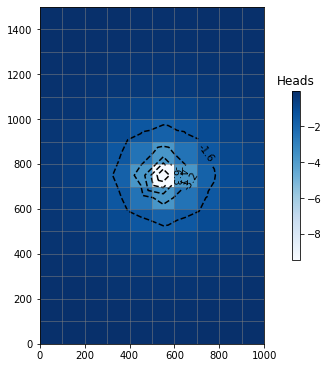

In [18]:
def plot_heads():
    hds = gwf.output.head()
    heads = hds.get_alldata()

    head = heads[-1]

    fig = plt.figure(figsize=(5, 5), constrained_layout=True)
    # first instantiate a PlotMapView
    mm = flopy.plot.PlotMapView(model=gwf, layer=0)

    # Plot heads
    # plot the array of heads 
    head_array = mm.plot_array(head, cmap='Blues')
    # add contour lines with contour_array()
    contours = mm.contour_array(head, colors='black')
    # add labels to contour lines
    plt.clabel(contours, fmt="%2.1f")
    # add a color bar
    cb = plt.colorbar(head_array, shrink=0.5, )
    cb.ax.set_title('Heads')
    # Plot grid 
    # you can plot BC cells using the plot_bc() 
    #mm.plot_bc('CHD', color='blue', alpha=0.2)
    # and plot the model grid if desired
    mm.plot_grid(lw=0.5)
    return

plot_heads()

# MODFLOW API

In [19]:
from modflowapi import ModflowApi

In [20]:
def get_rhs_per_node(tot_vol_in, nodes):
    node_height = tot_vol_in / cell_areas[nodes].sum()
    node_vols = node_height * cell_areas[nodes]
    return node_vols

In [21]:
def set_mar_rhs(nodes, tot_vol_in):
    node_vols = get_rhs_per_node(tot_vol_in, nodes)
    # now we can update the MAR package RHS variable
    # we need to assign new values only to the correct indices which correpsond to MAR nodes
    # this requires finding the array indeiices which corresnpodn to the MAR
    node_indices = np.where(np.in1d(mar_nodes, nodes))[0]
    rhs[node_indices] = -1 * node_vols #-1 because recharge is subtracted from RHS
    return



In [22]:
mf6 = ModflowApi(mf6_dll, working_directory=sim_ws)
mf6.initialize()
input_vars = mf6.get_input_var_names()
mf6.finalize()

In [23]:
input_vars

('TDIS/NPER',
 'TDIS/ITMUNI',
 'TDIS/KPER',
 'TDIS/KSTP',
 'TDIS/INATS',
 'TDIS/READNEWDATA',
 'TDIS/ENDOFPERIOD',
 'TDIS/ENDOFSIMULATION',
 'TDIS/DELT',
 'TDIS/PERTIM',
 'TDIS/TOTIM',
 'TDIS/TOTIMC',
 'TDIS/DELTSAV',
 'TDIS/TOTIMSAV',
 'TDIS/PERTIMSAV',
 'TDIS/TOTALSIMTIME',
 'TDIS/PERLEN',
 'TDIS/NSTP',
 'TDIS/TSMULT',
 'GWF/ID',
 'GWF/IOUT',
 'GWF/INEWTON',
 'GWF/IPRPAK',
 'GWF/IPRFLOW',
 'GWF/IPAKCB',
 'GWF/IDSOLN',
 'GWF/NEQ',
 'GWF/NJA',
 'GWF/ICNVG',
 'GWF/MOFFSET',
 'GWF/INIC',
 'GWF/INOC',
 'GWF/INNPF',
 'GWF/INBUY',
 'GWF/INSTO',
 'GWF/INCSUB',
 'GWF/INMVR',
 'GWF/INHFB',
 'GWF/INGNC',
 'GWF/INOBS',
 'GWF/ISS',
 'GWF/INEWTONUR',
 'GWF/DIS/INUNIT',
 'GWF/DIS/IOUT',
 'GWF/DIS/NODES',
 'GWF/DIS/NODESUSER',
 'GWF/DIS/NDIM',
 'GWF/DIS/ICONDIR',
 'GWF/DIS/WRITEGRB',
 'GWF/DIS/XORIGIN',
 'GWF/DIS/YORIGIN',
 'GWF/DIS/ANGROT',
 'GWF/DIS/NJA',
 'GWF/DIS/NJAS',
 'GWF/DIS/LENUNI',
 'GWF/DIS/NLAY',
 'GWF/DIS/NROW',
 'GWF/DIS/NCOL',
 'GWF/NPF/ID',
 'GWF/NPF/INUNIT',
 'GWF/NPF/IOUT',
 'GWF/

In [24]:
def get_drn_vol(nodes):
    drn_nodelist = mf6.get_value(f'{name}/DRN-0/NODELIST') - 1
    drn_bound = mf6.get_value(f'{name}/DRN-0/BOUND')
    drn_elev = [i[0] for i in drn_bound]
    drn_cond = [i[-1] for i in drn_bound]
    drn_rhs = mf6.get_value(f'{name}/DRN-0/RHS')
    drn_hcof = mf6.get_value(f'{name}/DRN-0/HCOF')
    drn_areas = cell_areas[drn_nodelist]

    drn_vol = abs(mf6.get_value(f'{name}/DRN-0/SIMVALS')).sum()

    dh = head[drn_nodelist] - drn_elev
    dh[dh<0]=0.

    drn_vol = (dh*drn_hcof)#/drn_areas
    node_indices = np.where(np.in1d(drn_nodelist, nodes))[0]
    drn_vol = drn_vol[node_indices]
    return abs(drn_vol)

In [25]:
# We will access package variables using the model and package Names
name = gwf.name.upper()
mar_package_name =  api_package.name[0].upper() 

# start the API
print('Starting MF6 API managed run.')
mf6 = ModflowApi(mf6_dll, working_directory=sim_ws)
# initialize the model
mf6.initialize()

# get the API package NBOUND so that we can update it.
nbound_address = mf6.get_var_address("NBOUND", name.upper(), mar_package_name)
nodelist_address = mf6.get_var_address("NODELIST", name.upper(), mar_package_name)
# access the values
# .get_value() returns a copy; .get_value_ptr() returns a pointer to the values
nbound = mf6.get_value_ptr(nbound_address)
# get the nodelist for accesing later on
mar_nodelist = mf6.get_value(nodelist_address)

# we will assign recharge by accesign the RHS (righ-hand-side) variable
# for recharge, recharge rate per cell is added to RHS; see the MF6 manual re-RCH package
rhs_address = mf6.get_var_address("RHS", name.upper(), mar_package_name)
# access rhs to provide a data structure for assigning later on
rhs = mf6.get_value(rhs_address)


# get pointer to simulated heads; we will use this at the iteration level 
# to calcualte if MAR must be redistributed
head_tag = mf6.get_var_address("X", name.upper())
head = mf6.get_value_ptr(head_tag)

# get cell tops
top_address = mf6.get_var_address("TOP", name.upper(), "DIS")
cell_top = mf6.get_value(top_address)

# get cell areas
area_address = mf6.get_var_address("AREA", name.upper(), "DIS")
cell_areas = mf6.get_value(area_address)


# get areas for mar nodes;
# get the MAR node numbers from lay,row,col
mar_node_n = gwf.modelgrid.get_node([(0,5,5), (0,5,6), (0,5,7)])
mar_node_s = gwf.modelgrid.get_node([(0,9,5), (0,9,6), (0,9,7)])

# set the MAR package NODELIST
mar_nodes = mar_node_n.copy()
mar_nodes.extend(mar_node_s)
mar_nodes=np.array(mar_nodes, dtype=np.int32)
# update the NBOUND
nbound[0] = mar_nodes.shape[0]
# update the nodelist values
mf6.set_value(nodelist_address, mar_nodes)

# areas is for all nodes, thus the index value conveniently corresponds to node number
mar_node_n_areas = cell_areas[mar_node_n]
mar_node_s_areas = cell_areas[mar_node_s]


# time loop
current_time = mf6.get_current_time()
end_time = mf6.get_end_time()

# model time loop
while current_time < end_time:
    print('Time:', current_time)
    # get dt and prepare for non-linear iterations
    dt = mf6.get_time_step()
    mf6.prepare_time_step(dt)

    # convergence loop
    kiter = 0
    mf6.prepare_solve(1)

    address = ["MXITER", "SLN_1"]
    mxittag = mf6.get_var_address(*address)
    mxit = mf6.get_value_ptr(mxittag)

    factor = 1.0
    offset = 0
    
    offset = 0
    while kiter < mxit:
        # get dewater volumes
        wel_vol = abs(mf6.get_value(f'{name}/WEL-1/RHS')).sum()
        
        # only MAR in 2nd SPD
        if current_time>1:
            drn_vol = get_drn_vol(mar_node_n).sum()
            print('start iter:',drn_vol)
            # how to avoid crazy rates...?
            # solve inner loop
            
            #if abs(get_drn_vol().sum() - offset) > 1e-6:
            if get_drn_vol(mar_node_n).sum() > 1e-6:
                while has_converged==False:
                    mar_vol_n = wel_vol - offset
                    # mar_s gets the rest of the well vol
                    mar_vol_s = wel_vol - mar_vol_n
                    # update the API package RHS
                    set_mar_rhs(mar_node_n, mar_vol_n)
                    set_mar_rhs(mar_node_s,  mar_vol_s)
                    mf6.set_value(rhs_address, rhs)  
                    has_converged = mf6.solve(1)
                    print(has_converged)

                drn_vol = get_drn_vol(mar_node_n).sum()
                print('mid iter:',drn_vol)
                offset = offset + drn_vol
            # SOlve Outer Loop
            # assign MAR volumes
            # mar_n gets wel_vol, minus what is rejected
            mar_vol_n = wel_vol - offset
            print('mar n:',mar_vol_n)
            # mar_s gets the rest of the well vol
            mar_vol_s = wel_vol - mar_vol_n
            print('mar s:',mar_vol_s)
            
            # update the API package RHS
            set_mar_rhs(mar_node_n, mar_vol_n)
            set_mar_rhs(mar_node_s,  mar_vol_s)
            mf6.set_value(rhs_address, rhs)  
    
        # solve iteration
        has_converged = mf6.solve(1)
        print('end iter:',get_drn_vol(mar_node_n).sum())
        offset = offset + get_drn_vol(mar_node_n).sum()

        kiter += 1
        if has_converged:
            offset=0
            break

    # Finalize the time step
    mf6.finalize_solve(1)
    #print('Model simulation time:', current_time, 'mar_n:',mar_vol_n, 'mar_s:',mar_vol_s )
    # finalize time step and update time
    mf6.finalize_time_step()
    current_time = mf6.get_current_time()
# finish the run
mf6.finalize()
print('MF6 terminated sucesfully.')

Starting MF6 API managed run.
Time: 0.0
end iter: 0.0
end iter: 0.0
end iter: 0.0
end iter: 0.0
end iter: 0.0
end iter: 0.0
end iter: 0.0
Time: 1.0
end iter: 0.0
end iter: 0.0
end iter: 0.0
end iter: 0.0
Time: 11.0
start iter: 0.0
mar n: 270.0
mar s: 0.0
end iter: 0.0
start iter: 0.0
mar n: 270.0
mar s: 0.0
end iter: 0.0
start iter: 0.0
mar n: 270.0
mar s: 0.0
end iter: 0.0
start iter: 0.0
mar n: 270.0
mar s: 0.0
end iter: 0.0
Time: 21.0
start iter: 0.0
mar n: 270.0
mar s: 0.0
end iter: 0.0
start iter: 0.0
mar n: 270.0
mar s: 0.0
end iter: 0.0
start iter: 0.0
mar n: 270.0
mar s: 0.0
end iter: 0.0
start iter: 0.0
mar n: 270.0
mar s: 0.0
end iter: 0.0
Time: 31.0
start iter: 0.0
mar n: 270.0
mar s: 0.0
end iter: 0.0
start iter: 0.0
mar n: 270.0
mar s: 0.0
end iter: 23.765617203852507
start iter: 23.765617203852507
False
False
False
True
mid iter: 10.092453787313715
mar n: 236.14192900883378
mar s: 33.858070991166215
end iter: 6.426757988831078
start iter: 6.426757988831078
False
False
Tru

In [31]:
inc1, cum1 = extract_hds_arrays_and_list_dfs(sim_ws)
inc1.loc[:,'mar'] = inc1.api +inc1.drn
inc1.tail()

budget values written to: inc.csv,cum.csv


,api,chd,drn,in-out,percent-discrepancy,sto-ss,sto-sy,total,wel,mar
totim,,,,,,,,,,
961.0,204.433899,0.0,-0.012394,2.030400e-09,0.0,-0.000326,0.012799,0.0,-204.433899,204.421509
971.0,204.360001,0.0,-0.013835,1.966200e-09,0.0,-0.000321,0.014200,0.0,-204.360001,204.346161
981.0,204.287399,0.0,-0.015272,1.950800e-09,0.0,-0.000316,0.015600,0.0,-204.287399,204.272125
991.0,204.216003,0.0,-0.016706,1.959300e-09,0.0,-0.000311,0.017099,0.0,-204.216003,204.199295
1001.0,204.145905,0.0,-0.018136,2.009200e-09,0.0,-0.000307,0.018500,0.0,-204.145905,204.127762


In [32]:
mar_nodes.shape[0], nbound[0]

(6, 413085600)

<AxesSubplot:xlabel='totim'>

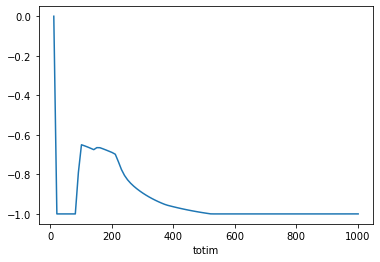

In [33]:
(inc1.mar/inc1.wel).plot()

<AxesSubplot:xlabel='totim'>

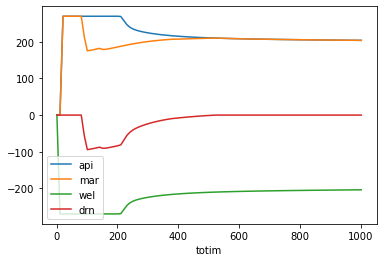

In [34]:
inc1.plot(y=['api','mar', 'wel', 'drn'])

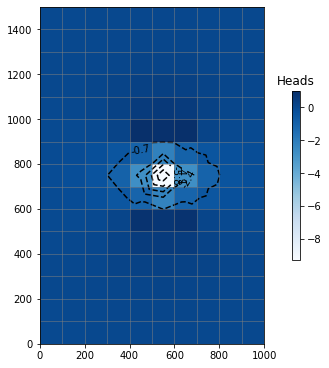

In [35]:
plot_heads()